# Malakal Sea Level Flood Frequency Counts

In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from urllib.request import urlretrieve
from pycurrents.data.timetools import dt64_to_ymdhms

## Access Malakal Data from UHSLC

In [2]:
#Access Malakal Data
datadir = './'
url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/"
fname = "h007.nc"
path = os.path.join(datadir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path)
    
data_xr = xr.open_dataset(fname)
data_xr

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 474393)
Coordinates:
  * time                  (time) datetime64[ns] 1969-05-18T15:00:00 ... 2023-...
  * record_id             (record_id) int16 70
Data variables:
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S7 ...
    station_country       (record_id) |S5 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    last_rq_date          (record_id) datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-08-28T14:34:57Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [3]:
station = str(data_xr.station_name.values)[3:10]
country = str(data_xr.station_country.values)[3:8]
f"Station: {station}, {country}"


'Station: Malakal, Palau'

### Plot full time series

In [4]:
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
ax.plot(data_xr.time.values,data_xr.sea_level.T.values/10)

ax.set_ylabel('Sea Level  (cm)',fontsize=15)
fig.suptitle(f"{station}: Full Time Series",fontsize=18)

Text(0.5, 0.98, 'Malakal: Full Time Series')

## Identify epoch for the flood frequency analysis

Calculate trend for the 1993-2022 epoch


In [5]:
#get data between 1993 and 2022
epoch = [1993,2022]
epoch_start = f"{epoch[0]}-01-01"
epoch_end = f"{epoch[-1]}-12-31"

data_epoch= data_xr.sel(dict(time=slice(epoch_start, epoch_end)))
data_epoch['sea_level'] = data_epoch.sea_level/10 #convert mm to cm
data_epoch

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 262968)
Coordinates:
  * time                  (time) datetime64[ns] 1993-01-01 ... 2022-12-31T22:...
  * record_id             (record_id) int16 70
Data variables:
    sea_level             (record_id, time) float32 147.6 167.0 ... 135.3 127.0
    lat                   (record_id) float32 7.33
    lon                   (record_id) float32 134.5
    station_name          (record_id) |S7 b'Malakal'
    station_country       (record_id) |S5 b'Palau'
    station_country_code  (record_id) float32 585.0
    uhslc_id              (record_id) int16 7
    gloss_id              (record_id) float32 120.0
    ssc_id                (record_id) |S4 b'mala'
    last_rq_date          (record_id) datetime64[ns] 2018-12-31T22:59:59.971200
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-08-28T14:34:57Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

## Calculate flood frequency counts

In [6]:
T = data_epoch.time.values
SL = data_epoch.sea_level.values.T

start_year = epoch[0]
end_year = epoch[-1]
num_years = end_year - start_year + 1
num_months = 12
num_days = 31
num_hours = 24

dat_yyyymmddhh = np.full((num_years, num_months, num_days, num_hours), np.nan)

# Account for Leap Year
daysInMonth_noLeap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
daysInMonth_Leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])


for year in range(num_years):
    if (((year+start_year) % 4 == 0) and ((year+start_year) % 100 != 0)) or ((year+start_year) % 400 == 0):
        calendar = daysInMonth_Leap
    else:
        calendar = daysInMonth_noLeap
    for month in range(num_months):
        # Calculate the effective month index (starting from May)
        effective_month = (month + 4) % 12  # 0-indexed, May corresponds to index 4
        
        # Define the start date for the current month
        if month < 8:
            start_date = np.datetime64(f'{year + start_year}-{effective_month + 1:02d}-01T00:00:00')
        else:
            start_date = np.datetime64(f'{year + start_year+1}-{effective_month + 1:02d}-01T00:00:00')
                
        
         # Calculate the number of days in the current month
        num_days_in_month = calendar[effective_month]
        
         # Calculate the end date for the current month
        end_date = start_date + np.timedelta64(num_days_in_month - 1, 'D') + np.timedelta64(23, 'h') + np.timedelta64(59, 'm') + np.timedelta64(59, 's')

        mask = (T >= start_date) & (T <= end_date)
        if not mask.any():
            dat_yyyymmddhh[year, month, :num_days_in_month, :] = np.nan
        else:
            dat_yyyymmddhh[year, month, :num_days_in_month, :] = SL[mask].reshape((num_days_in_month,num_hours))   
        

In [7]:
#threshold (cm) from  stationary GPD
threshold = 260.9674
condition_met = dat_yyyymmddhh[:,:,:,:] > threshold
freq_count_yr = np.sum(np.sum(np.sum(condition_met, axis=3),axis=2),axis=1)

### Plot Flood Frequency Counts 

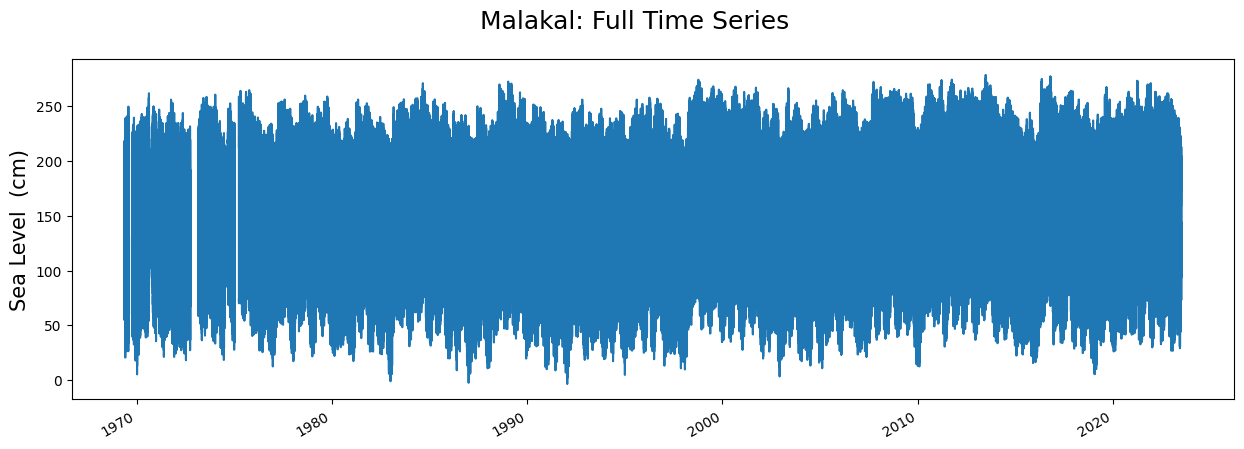

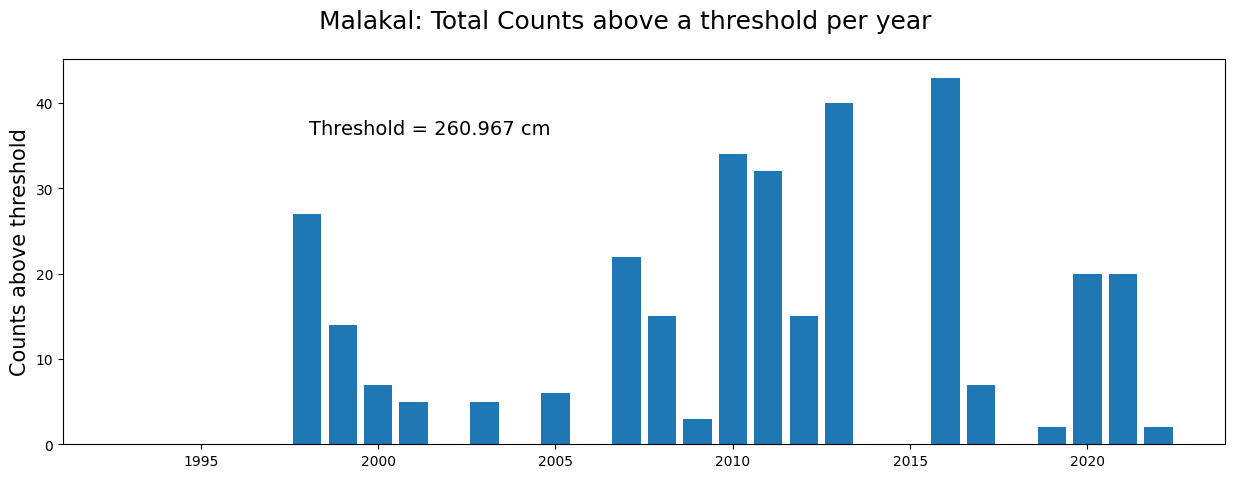

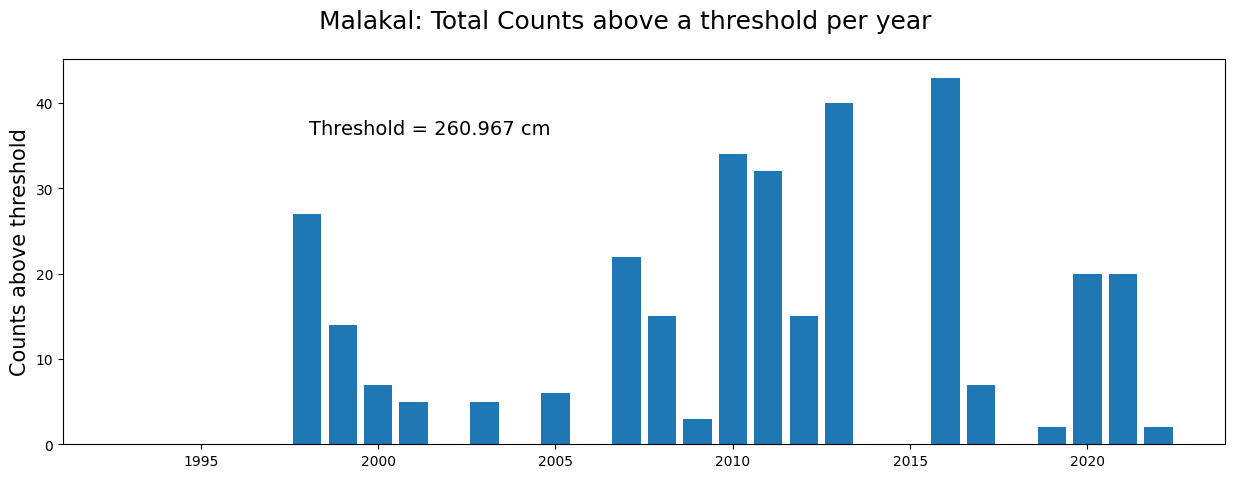

In [9]:
yr = np.arange(epoch[0],epoch[-1]+1)
fig, ax = plt.subplots(figsize=[15,5])
ax.bar(yr,freq_count_yr)
ax.set_ylabel('Counts above threshold',fontsize=15)
fig.suptitle(f"{station}: Total Counts above a threshold per year",fontsize=18)
ax.annotate(f'Threshold = {np.round(threshold,3)} cm',xy=(.25,.75),xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=14)
plt.show()